<a href="https://colab.research.google.com/github/NaHyeonMaeng/CODE_Practice/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 기본 설정
import numpy as np
import tensorflow as tf

num_classes = 10
input_shape = (32, 32, 3)
learning_rate = 0.0001
batch_size = 64
epoch_num= 20
num_heads = 8
trans_num = 8
img_patch_size = 4
p_i_num=int(32*32/4/4)
proj_num=32
class_num =10

In [2]:
# 데이터 다운로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 인코딩 값 정의
position_input = [range(64) for i in range(50000)]
position_input = np.array(position_input)
position_input = np.reshape(position_input, (50000,64,1))

# 모델 정의
i = tf.keras.Input(shape=input_shape)  #패치 배열
p_i = tf.keras.Input(shape=(p_i_num,1))  #인덱스 배열
out_patch = tf.image.extract_patches(images=i,
            sizes=[1, img_patch_size, img_patch_size, 1],
            strides=[1, img_patch_size, img_patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID")
out = tf.keras.layers.Reshape([-1,img_patch_size*img_patch_size*3])(out_patch)  #크기가 4*4*3인 1차원 배열로 펼쳐줌
p_out = tf.keras.layers.Embedding(p_i_num, proj_num)(p_i)  #트랜스포머 입력 형태인 크기 '32'로 줄임
p_out = tf.keras.layers.Reshape([-1,proj_num])(p_out)  #트랜스포머 입력 형태인 크기 '32'로 늘림
out = tf.keras.layers.Dense(proj_num)(out)
out = tf.keras.layers.Add()([out,p_out])

for _ in range(trans_num):
    out_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out)
    a_out = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                               key_dim=proj_num,
                                               dropout=0.1)(out_1, out_1)
    out_2 = tf.keras.layers.Add()([a_out, out])
    out_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out_2)
    out_3 = tf.keras.layers.Dense(proj_num *2, activation=tf.nn.gelu)(out_3)
    out_3 = tf.keras.layers.Dropout(0.1)(out_3)
    out_3 = tf.keras.layers.Dense(proj_num, activation=tf.nn.gelu)(out_3)
    out_3 = tf.keras.layers.Dropout(0.1)(out_3)
    out = tf.keras.layers.Add()([out_3, out_2])

out = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(1024, activation=tf.nn.gelu)(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(512, activation=tf.nn.gelu)(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = tf.keras.layers.Dense(class_num)(out)

vit_model = tf.keras.Model(inputs=[i,p_i], outputs=[out])  #패치 배열과 인덱스 배열을 더해서 트랜스포머의 입력으로 사용

# 모델 요약
vit_model.summary()

170498071/170498071 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 8, 8, 48)    0           ['input_1[0][0]']                
 Lambda)                                                                                          
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 1)]      0           []                               
                                                                                                  
 reshape (Reshape)         

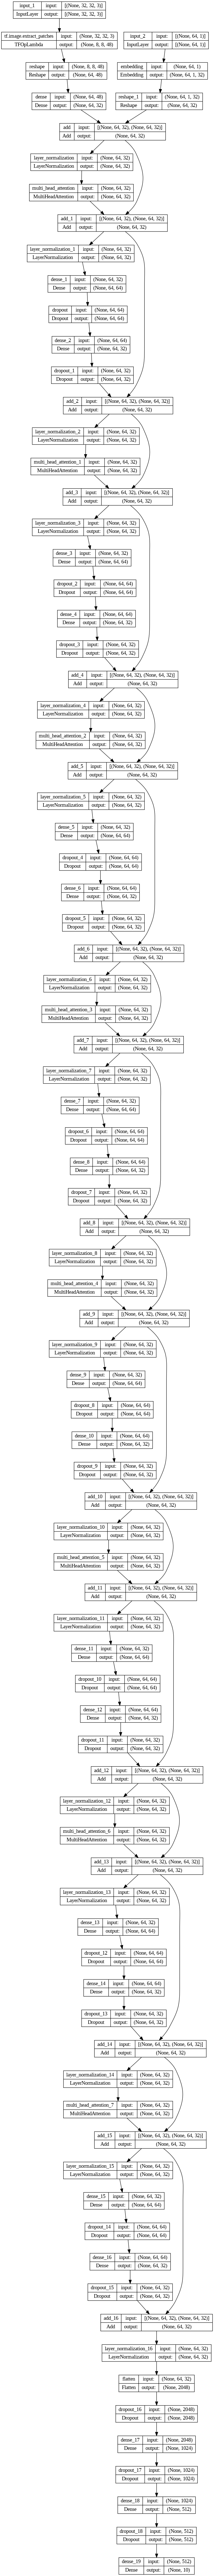

In [3]:
# 모델 구조
tf.keras.utils.plot_model(vit_model,show_shapes=True)

In [4]:
#앞에서 생성한 ViT 모델의 입력 이미지를 64개 패치로 구분된 이미지로 출력
vit_image_model=  tf.keras.Model(inputs=vit_model.inputs, outputs=vit_model.layers[1].output)
img=vit_image_model.predict([x_train[0:2],position_input[0:2]])
img.shape

1/1 [==============================] - 0s 128ms/step


(2, 8, 8, 48)

(-0.5, 31.5, 31.5, -0.5)

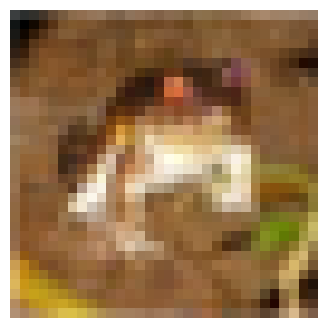

In [5]:
#원본 이지미 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

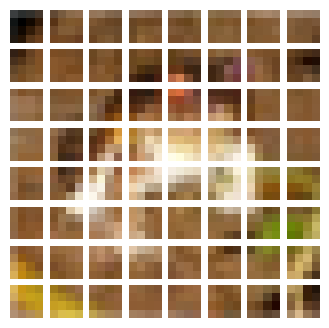

In [6]:
#64개 패치로 분할
plt.figure(figsize=(4, 4))
for i in range(8):
    for j in range(8):
        ax = plt.subplot(8, 8, i*8 +j+1)
        sub_img=np.reshape(img[0,i,j,:],(4,4,3))
        plt.imshow(sub_img.astype("uint8"))
        plt.axis("off")

In [7]:
#모델 훈련
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

vit_model.fit(x=[x_train,position_input],
              y=y_train,
              batch_size=batch_size,
              epochs=epoch_num,
              validation_split=0.3)

Epoch 1/20
547/547 [==============================] - 74s 68ms/step - loss: 2.0801 - accuracy: 0.2415 - top-5-accuracy: 0.7419 - val_loss: 1.9209 - val_accuracy: 0.2829 - val_top-5-accuracy: 0.8203
Epoch 2/20
547/547 [==============================] - 35s 64ms/step - loss: 1.7340 - accuracy: 0.3704 - top-5-accuracy: 0.8665 - val_loss: 1.6724 - val_accuracy: 0.4001 - val_top-5-accuracy: 0.8777
Epoch 3/20
547/547 [==============================] - 36s 65ms/step - loss: 1.5635 - accuracy: 0.4379 - top-5-accuracy: 0.8975 - val_loss: 1.5483 - val_accuracy: 0.4479 - val_top-5-accuracy: 0.9023
Epoch 4/20
547/547 [==============================] - 37s 68ms/step - loss: 1.4463 - accuracy: 0.4773 - top-5-accuracy: 0.9205 - val_loss: 1.4704 - val_accuracy: 0.4749 - val_top-5-accuracy: 0.9162
Epoch 5/20
547/547 [==============================] - 35s 65ms/step - loss: 1.3510 - accuracy: 0.5136 - top-5-accuracy: 0.9331 - val_loss: 1.4008 - val_accuracy: 0.4972 - val_top-5-accuracy: 0.9283
Epoch 6/20